In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [2]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,category,inflation,GBP_EUR,BTC_GBP,unemploy_rate
0,47,13,1,1.0,1,0,0,0,1,0,regular,NaN,NaN,NaN,1.3,1.16935,6347.577148,3.9
1,99001309,14,0,100.0,0,0,1,0,0,0,regular,NaN,1.0,NaN,1.3,1.18803,5630.115723,4.0
2,804,19,1,100.0,1,0,0,0,1,0,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
3,812,19,1,100.0,1,0,0,1,1,0,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
4,191,19,1,100.0,1,0,0,0,1,0,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,0,2,2,0,1,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32088,39339,23,6,100.0,0,3,3,0,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32089,24505,23,6,50.0,1,2,2,3,4,4,instant,NaN,NaN,NaN,0.7,0.00000,10627.522461,5.3
32090,100781,23,6,60.0,0,1,1,0,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3


In [3]:
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']

In [4]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              32092 non-null  int64  
 1   created_at_slot      32092 non-null  int32  
 2   created_at_dow       32092 non-null  int32  
 3   amount               32092 non-null  float64
 4   needs_m_check_recov  32092 non-null  int64  
 5   n_fees               32092 non-null  int64  
 6   n_backs              32092 non-null  int64  
 7   n_recovery           32092 non-null  int64  
 8   n_inc_back           32092 non-null  int64  
 9   n_inc_fees           32092 non-null  int64  
 10  transfer_type        32092 non-null  object 
 11  charge_moment        21055 non-null  object 
 12  n_cr_fe_w            23171 non-null  float64
 13  category             21055 non-null  object 
 14  inflation            32092 non-null  float64
 15  GBP_EUR              32092 non-null 

In [5]:
# Convertir las columnas de tipo timedelta64
#for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [6]:
# Convertir las columnas de tipo datetime64
#for col in X_log_L.select_dtypes(include=['datetime64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [5]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [6]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [7]:
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [8]:
X_log_L.describe()

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
count,3.209200e+04,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.00000,32092.000000,32092.000000,32092.000000,32092.000000
mean,7.967657e+06,12.648137,2.748847,83.516733,0.523121,0.978375,1.459491,0.711143,0.935498,1.085224,1.008787,0.632940,0.883637,8387.211870,4.92357,0.392746,0.135112,0.587685,0.049794
std,2.687968e+07,5.272898,1.828468,25.900555,0.499473,1.126548,1.393508,1.701936,1.773505,2.173606,0.874855,0.287033,0.445121,1037.083991,0.34973,0.488369,0.341848,0.492259,0.217523
min,3.400000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,3954.907959,3.90000,0.000000,0.000000,0.000000,0.000000
25%,1.253700e+04,9.000000,1.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.090690,7574.018555,4.70000,0.000000,0.000000,0.000000,0.000000
50%,2.700500e+04,13.000000,3.000000,100.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.600000,1.102660,8435.253906,5.00000,0.000000,0.000000,1.000000,0.000000
75%,5.547150e+04,17.000000,4.000000,100.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.700000,1.108140,8948.752930,5.20000,1.000000,0.000000,1.000000,0.000000
max,9.903044e+07,23.000000,6.000000,200.000000,1.000000,15.000000,11.000000,28.000000,21.000000,33.000000,13.000000,1.800000,1.204510,10645.804688,5.30000,1.000000,1.000000,1.000000,1.000000


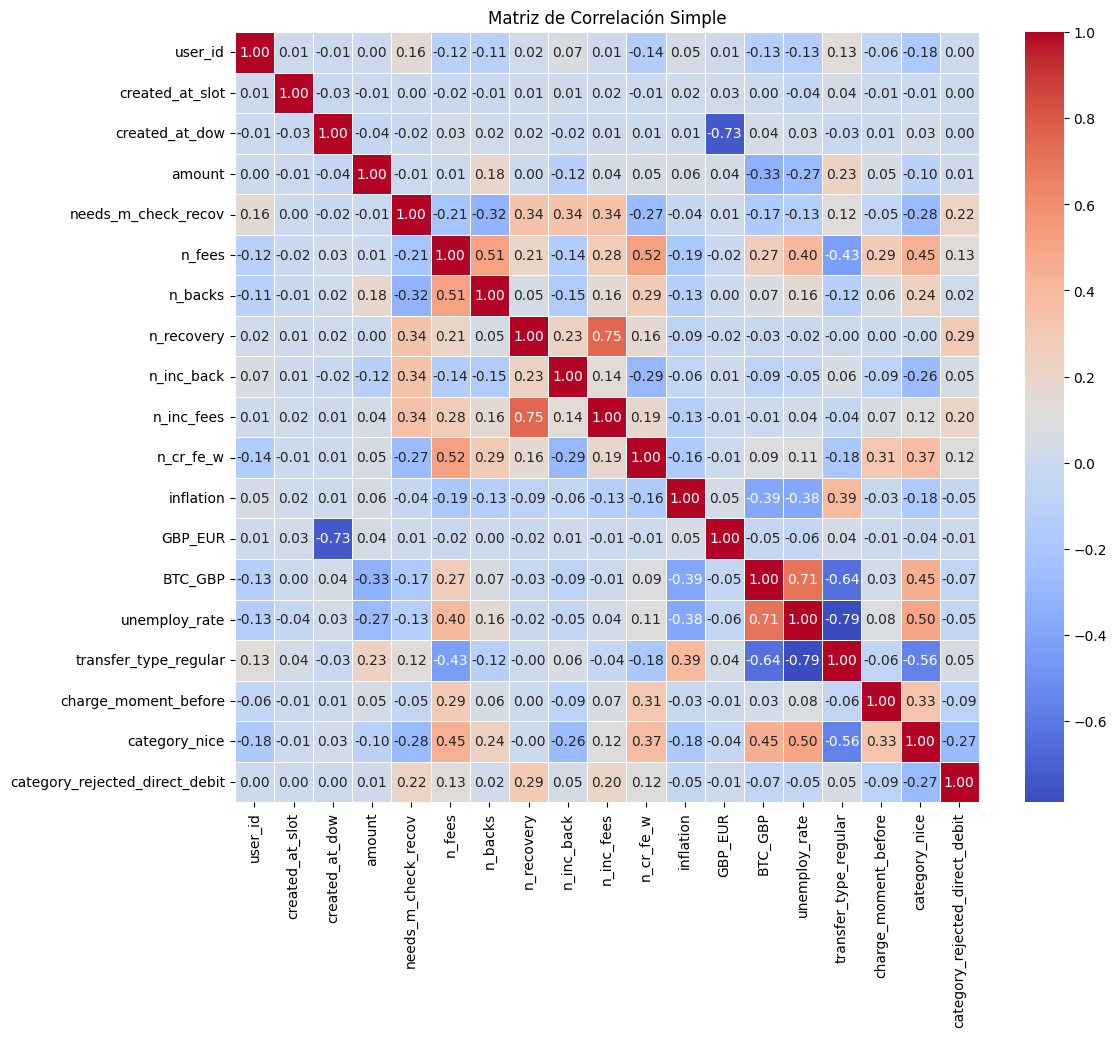

In [9]:
# Calcular la matriz de correlación
m_corr = X_log_L.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [11]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso MINMAXSCALER
scaler = MinMaxScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)

# Visualización de datos después del escalador
display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,47,13,1,1.0,1,0,0,0,1,0,0.0,1.3,1.16935,6347.577148,3.9,1,0,0,0
1,99001309,14,0,100.0,0,0,1,0,0,0,1.0,1.3,1.18803,5630.115723,4.0,1,0,0,0
2,804,19,1,100.0,1,0,0,0,1,0,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
3,812,19,1,100.0,1,0,0,1,1,0,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
4,191,19,1,100.0,1,0,0,0,1,0,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
5,430,19,1,100.0,1,0,1,1,0,1,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
6,761,19,1,99.0,1,0,0,0,1,0,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
7,735,19,1,100.0,0,0,1,0,0,0,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
8,406,19,1,100.0,1,0,0,1,1,0,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
9,140,19,1,100.0,0,0,1,0,0,0,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,1.312728e-07,0.565217,0.166667,0.000000,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.6875,0.970810,0.357601,0.000000,1.0,0.0,0.0,0.0
1,9.997058e-01,0.608696,0.000000,0.497487,0.0,0.090909,0.000000,0.000000,0.000000,0.076923,0.6875,0.986318,0.250371,0.071429,1.0,0.0,0.0,0.0
2,7.775389e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
3,7.856173e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.035714,0.047619,0.000000,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
4,1.585372e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
5,3.998772e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.035714,0.000000,0.030303,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
6,7.341179e-06,0.826087,0.166667,0.492462,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
7,7.078634e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.000000,0.000000,0.000000,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
8,3.756422e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.035714,0.047619,0.000000,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
9,1.070378e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.000000,0.000000,0.000000,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_inc_fees: 27.08593279
n_recovery: 22.72214517
n_cr_fe_w: -10.66306819
n_fees: -9.34200182
n_inc_back: 9.25053724
n_backs: -7.98541451
category_rejected_direct_debit: 5.13803769
BTC_GBP: -2.05679212
amount: 1.36803772
inflation: -1.28040280
charge_moment_before: 0.90945450
user_id: 0.66757939
transfer_type_regular: -0.65496442
unemploy_rate: 0.57390917
category_nice: -0.30144942
GBP_EUR: 0.03982043
created_at_slot: -0.01771094
created_at_dow: -0.01146421

Multiplicadores de odds (elevando exp a los coeficientes):
n_inc_fees: 579790568230.01892090
n_recovery: 7380780049.73198986
n_cr_fe_w: 0.00002339
n_fees: 0.00008766
n_inc_back: 10410.15696963
n_backs: 0.00034039
category_rejected_direct_debit: 170.38110027
BTC_GBP: 0.12786348
amount: 3.92763602
inflation: 0.27792533
charge_moment_before: 2.48296772
user_id: 1.94951259
transfer_type_regular: 0.51946055
unemploy_rate: 1.77519304
category_nice: 0.73974524
GBP_EUR:

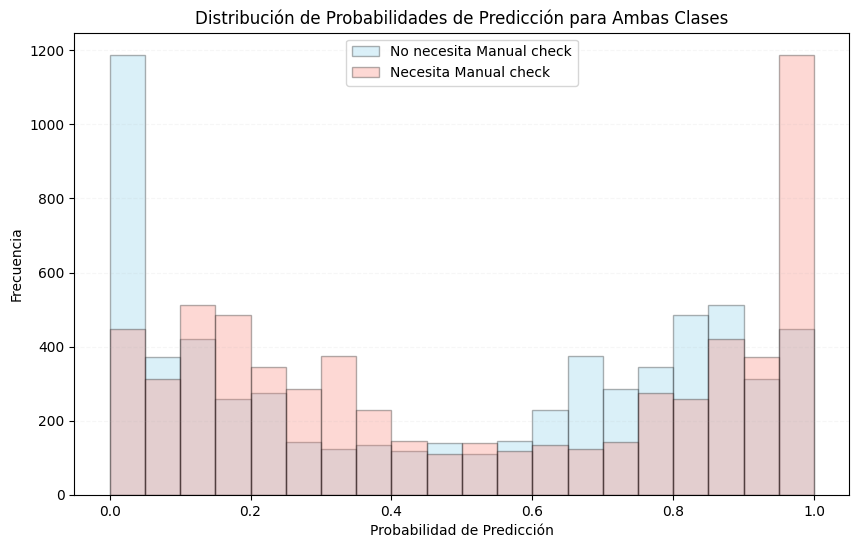

Accuracy: 0.9085527340707276
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      3005
           1       0.95      0.88      0.91      3414

    accuracy                           0.91      6419
   macro avg       0.91      0.91      0.91      6419
weighted avg       0.91      0.91      0.91      6419



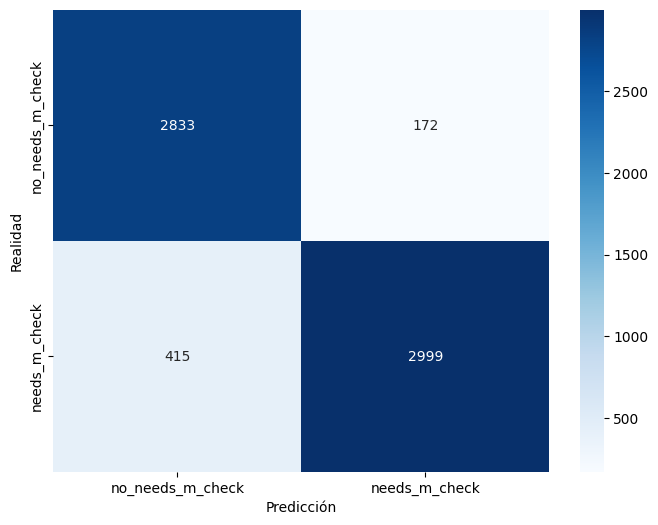

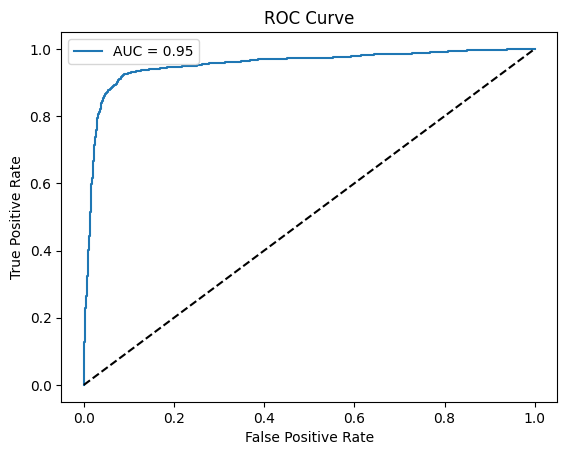

In [35]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con todas las caracteristicas para poder ver después la diferencia al aplicar Ridge y Lasso

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nMultiplicadores de odds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [13]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.9085527340707276
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3005
           1       0.92      0.92      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



Text(70.5815972222222, 0.5, 'Realidad')

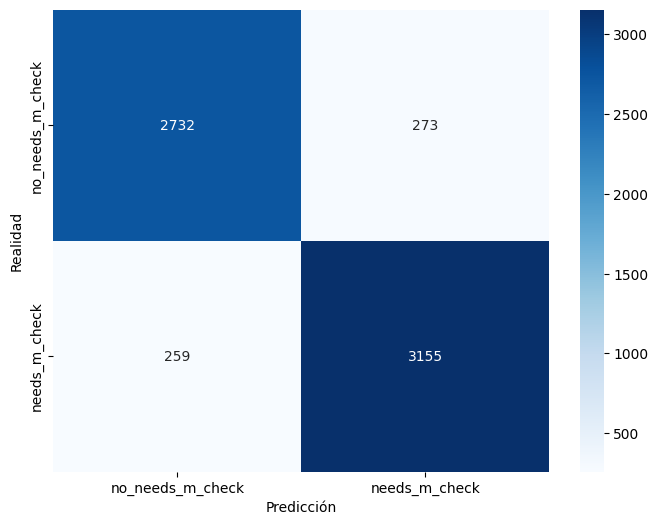

In [14]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [15]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica al modelo base 

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=10, random_state=42, max_iter=1000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=10, random_state=42, max_iter=1000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.9288051098301916
Exactitud L2 (Ridge): 0.9260009347250351


In [16]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l1 = list(zip(feature_names, coefs))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("\nCaracterísticas importantes para LASSO ordenadas por magnitud:")
print(importancia_no_nula)


Características importantes para LASSO ordenadas por magnitud:
                    Característica  Coeficiente
6                       n_recovery    44.541866
8                       n_inc_fees    39.757215
4                           n_fees   -18.097332
9                        n_cr_fe_w   -14.227508
7                       n_inc_back    10.827055
5                          n_backs    -9.669370
17  category_rejected_direct_debit     9.052452
12                         BTC_GBP    -2.383099
3                           amount     1.972817
15            charge_moment_before     1.376026
10                       inflation    -1.373261
14           transfer_type_regular    -1.055792
13                   unemploy_rate     0.819869
0                          user_id     0.622036
16                   category_nice    -0.166357
2                   created_at_dow    -0.046978
1                  created_at_slot    -0.031884
11                         GBP_EUR     0.013236


In [17]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l2 = list(zip(feature_names, coefs2))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
6                       n_recovery    39.226622
8                       n_inc_fees    36.697190
4                           n_fees   -16.107403
9                        n_cr_fe_w   -13.522641
17  category_rejected_direct_debit    13.119569
7                       n_inc_back    10.321726
5                          n_backs    -9.282330
12                         BTC_GBP    -2.351779
3                           amount     1.863368
10                       inflation    -1.364877
15            charge_moment_before     1.271711
14           transfer_type_regular    -0.957970
13                   unemploy_rate     0.799364
0                          user_id     0.623892
16                   category_nice    -0.188069
1                  created_at_slot    -0.043102
11                         GBP_EUR     0.039811
2                   created_at_dow    -0.015065


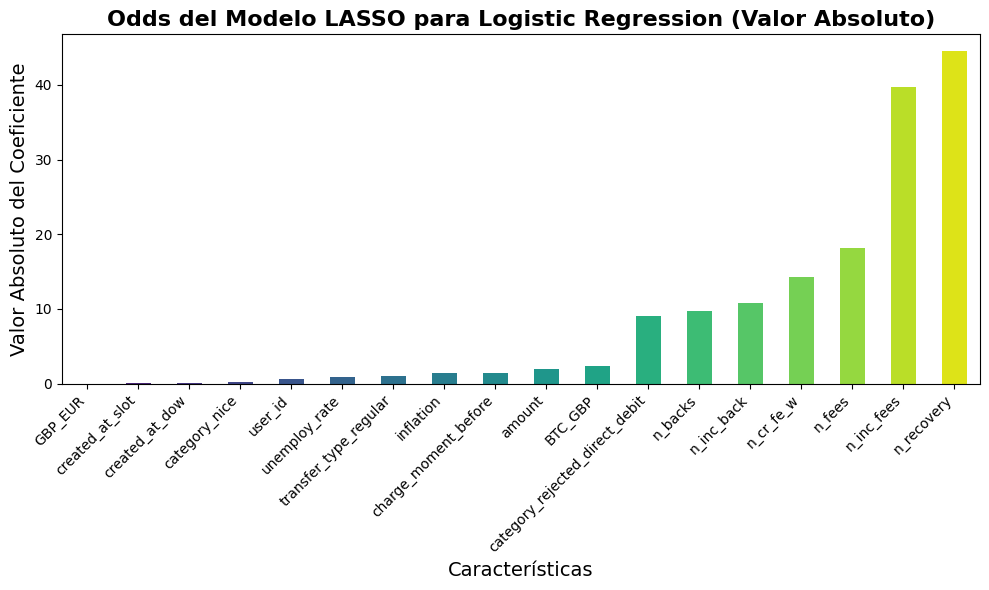

In [ ]:
# Graficamos los coeficientes ordenados por valor absoluto LASSO
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l1 = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l1 = coefs_series_l1.abs().sort_values(ascending=True)

# graficar
coefs_series_l1.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l1)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

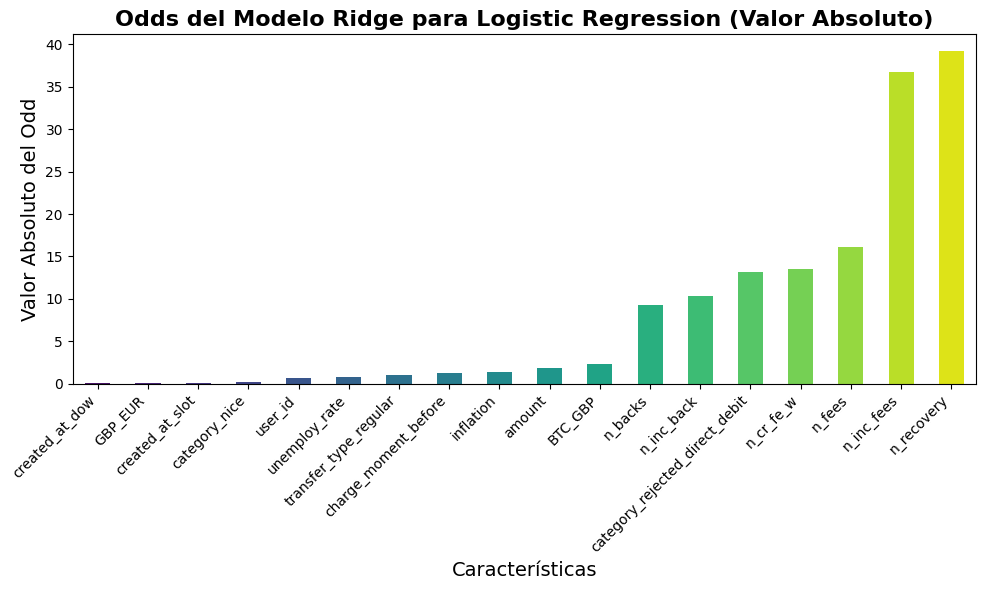

In [ ]:
# Graficamos los coeficientes ordenados por valor absoluto RIDGE
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l2 = coefs_series_l2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series_l2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l2)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Odd', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [ ]:
# Encontrar C optima de manera manual.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)
scores_l1 = []
scores_l2 = []

# Iterar manualmente para penalización L1
for C in C_values:
    model_l1 = LogisticRegression(
        C=C, penalty='l1', solver='saga', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l1.append(score)

# Iterar manualmente para penalización L2
for C in C_values:
    model_l2 = LogisticRegression(
        C=C, penalty='l2', solver='saga', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l2, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l2.append(score)

# Encontrar el mejor C
optimal_C_l1 = C_values[np.argmax(scores_l1)]
optimal_C_l2 = C_values[np.argmax(scores_l2)]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 21.54434690031882
Mejor valor de C para penalización L2: 1291.5496650148827


In [21]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones. Ahora con el LogisticRegressionCV que tiene Validación Cruzada incorporada.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='saga', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='saga', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 21.54434690031882
Mejor valor de C para penalización L2: 1291.5496650148827


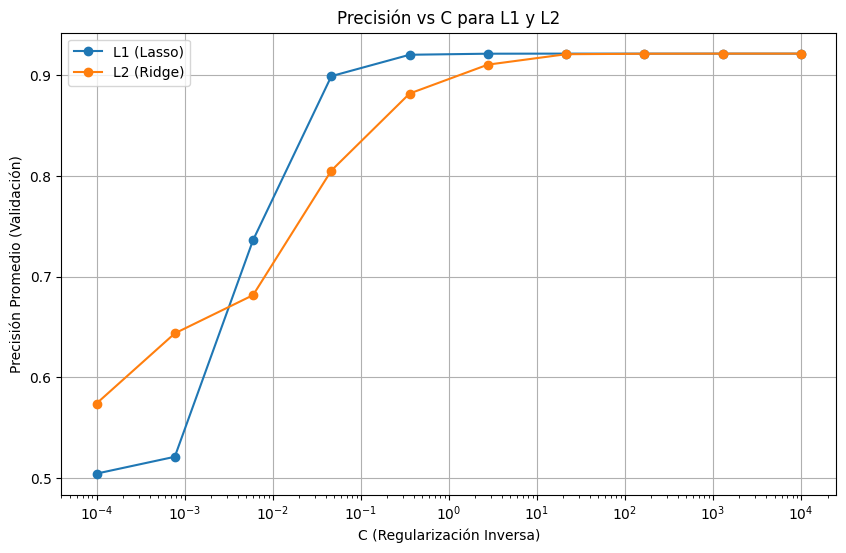

In [22]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

Podemos ver que para C pequeñas (alphas grandes) la precisión promedio baja a 0.5 y 0.6, es decir que el modelo es sensible a la regularización.

In [23]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"\nÍndice óptimo para L1: {optimal_index_l1} \nMejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"\nÍndice óptimo para L2: {optimal_index_l2} \nMejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.50418532 0.52093639 0.73629897 0.89927147 0.92053903 0.9215907
 0.9216686  0.9216686  0.9216686  0.9216686 ]
Puntajes promedio para L2: [0.5738714  0.64359439 0.68161091 0.80543774 0.8820159  0.91072318
 0.9210843  0.92155175 0.9216686  0.9216686 ]

Índice óptimo para L1: 6 
Mejor C: 21.54434690031882

Índice óptimo para L2: 8 
Mejor C: 1291.5496650148827


In [24]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='saga', C=optimal_C_l1, random_state=42, max_iter=1000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='saga', C=optimal_C_l2, random_state=42, max_iter=1000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(1291.5496650148827), max_iter=1000,
                   random_state=42, solver='saga')

In [25]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.9288051098301916
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      3005
           1       0.95      0.91      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419

Evaluación del modelo Ridge (L2):
Precisión: 0.9288051098301916
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      3005
           1       0.95      0.91      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_recovery: 44.70709745
n_inc_fees: 39.80709730
n_fees: -18.16853764
n_cr_fe_w: -14.25631729
n_inc_back: 10.84577326
category_rejected_direct_debit: 10.49459349
n_backs: -9.68018438
BTC_GBP: -2.39046718
amount: 1.98042760
charge_moment_before: 1.38067435
inflation: -1.37603432
transfer_type_regular: -1.05906510
unemploy_rate: 0.82440668
user_id: 0.62239660
category_nice: -0.16449180
created_at_dow: -0.04718906
created_at_slot: -0.03255523
GBP_EUR: 0.01341150

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
n_recovery: 44.67356668
n_inc_fees: 39.78875437
n_fees: -18.14754486
n_cr_fe_w: -14.24759689
n_inc_back: 10.83852393
n_backs: -9.67664601
category_rejected_direct_debit: 9.60481992
BTC_GBP: -2.38765950
amount: 1.97776101
charge_moment_before: 1.37930538
inflation: -1.37497700
transfer_type_regular: -1.05806389
unemploy_rate: 0.82269298
user_id: 0.62218319
category_nice: -0.16511167
created_at_dow: -0.04711568
c

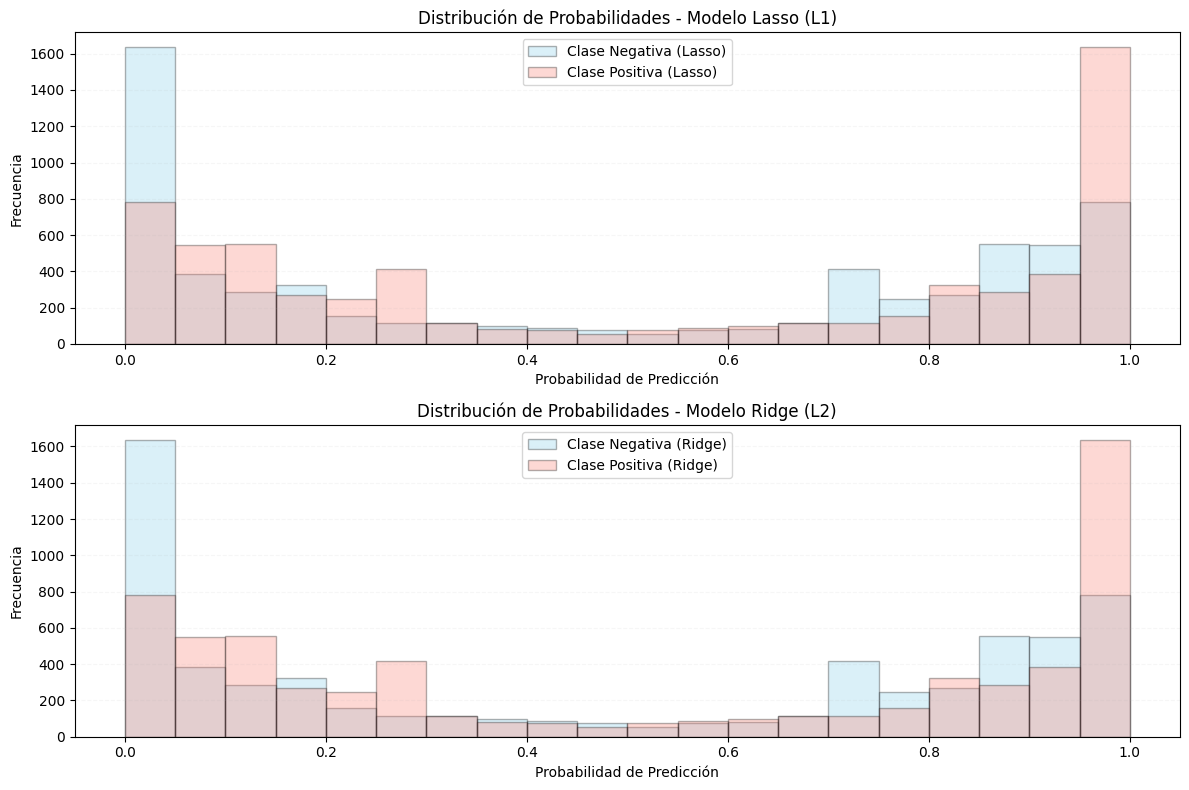

Desempeño del Modelo Lasso (L1):
Accuracy: 0.9288051098301916
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      3005
           1       0.95      0.91      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419


Desempeño del Modelo Ridge (L2):
Accuracy: 0.9288051098301916
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      3005
           1       0.95      0.91      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419



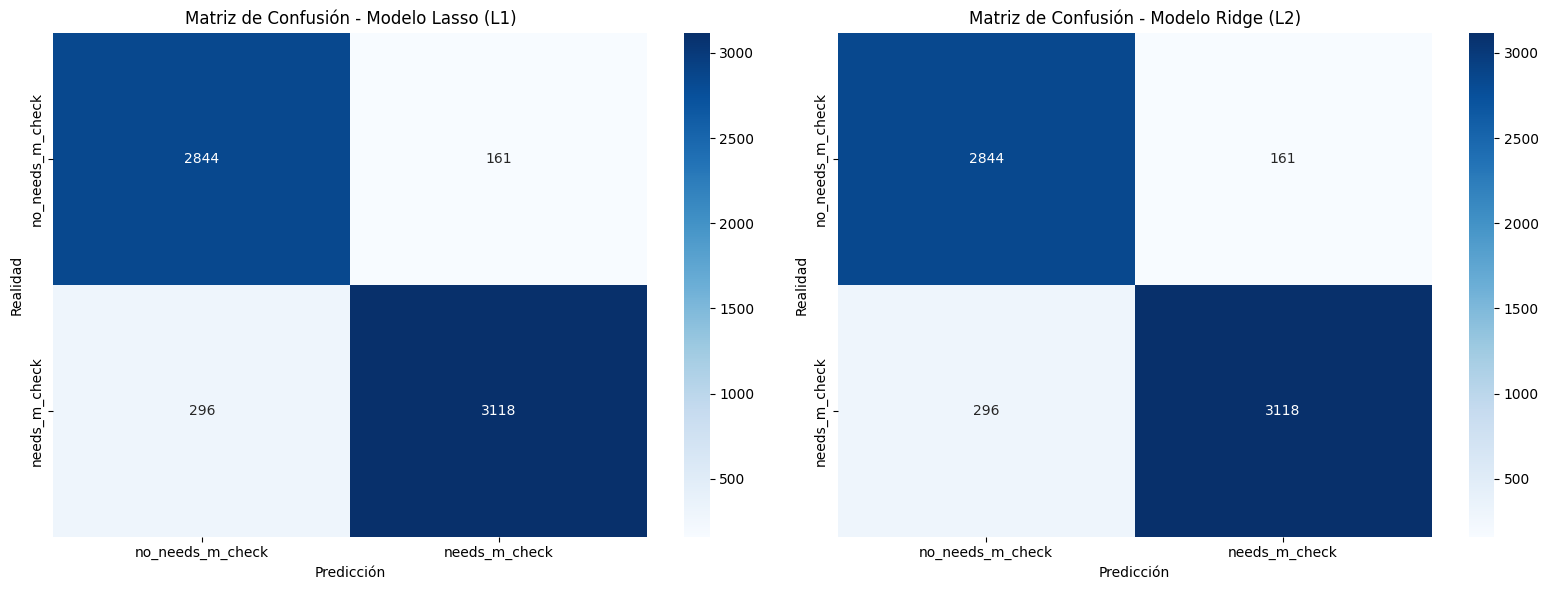

In [ ]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos
print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [27]:
# Comparación resultados entre MODELO BASE, el BASE con cambio de umbral y el modelo entrenado según LASSO y RIDGE

# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Base model con umbral modificado
accuracy_umbral = accuracy_score(y_test, predicciones_modificadas)
precision_umbral = precision_score(y_test, predicciones_modificadas)
recall_umbral = recall_score(y_test, predicciones_modificadas)
f1_umbral = f1_score(y_test, predicciones_modificadas)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla
metricas = {
    "R_LOGISTICA MaxMinScaler": ["Base", "Umbral 0.4","Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_umbral ,accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_umbral,precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_umbral, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_umbral, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_umbral, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  R_LOGISTICA MaxMinScaler  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0                     Base  0.908553   0.945758  0.878442  0.910858  0.910602
1               Umbral 0.4  0.917121   0.920362  0.924136  0.922245  0.916644
2                    Ridge  0.928805   0.950900  0.913298  0.931720  0.929860
3                    Lasso  0.928805   0.950900  0.913298  0.931720  0.929860


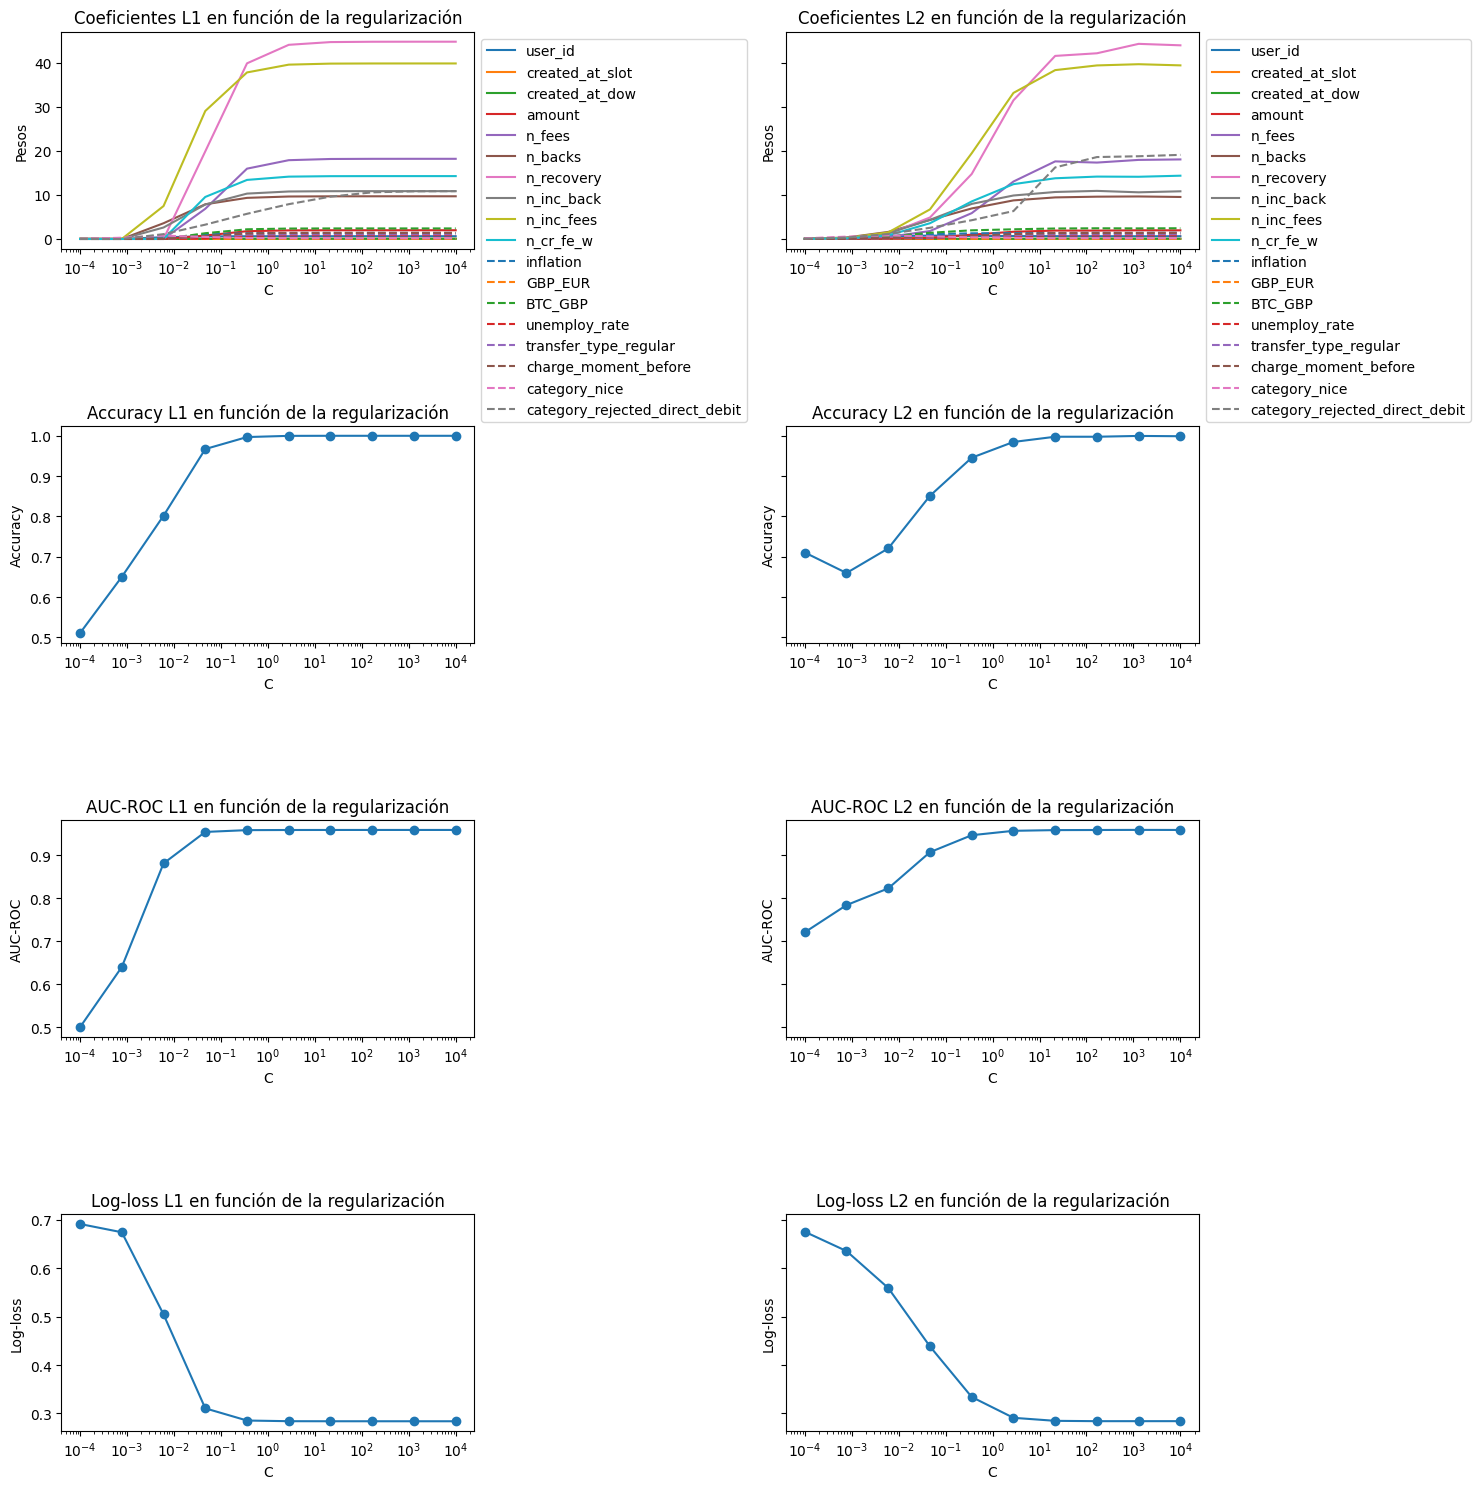

In [28]:
# Graficar el C (que es 1/alpha)

# Valores de C para probar (equivalente a 1/alpha en regresión logística)
C_values = np.logspace(-4, 4, 10)

# Inicialización de listas para almacenar resultados
coefs_logreg_l1 = []
coefs_logreg_l2 = []
accuracy_l1 = []
accuracy_l2 = []
auc_l1 = []
auc_l2 = []
logloss_l1 = []
logloss_l2 = []

# Modelos y evaluación
for C in C_values:
    # Penalización L1
    logreg_l1 = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=1000, random_state=42)
    logreg_l1.fit(X_train, y_train)
    coefs_logreg_l1.append(logreg_l1.coef_[0])  # Guardar coeficientes
    y_pred_prob_l1 = logreg_l1.predict_proba(X_test)[:, 1]  # Probabilidades para ROC y log-loss
    accuracy_l1.append(logreg_l1.score(X_test, y_pred_l1))
    auc_l1.append(roc_auc_score(y_test, y_pred_prob_l1))  # AUC-ROC
    logloss_l1.append(log_loss(y_test, y_pred_prob_l1))  # Log-loss

    # Penalización L2
    logreg_l2 = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000, random_state=42)
    logreg_l2.fit(X_train, y_train)
    coefs_logreg_l2.append(logreg_l2.coef_[0])  # Guardar coeficientes
    y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]
    accuracy_l2.append(logreg_l2.score(X_test, y_pred_l2))
    auc_l2.append(roc_auc_score(y_test, y_pred_prob_l2))  # AUC-ROC
    logloss_l2.append(log_loss(y_test, y_pred_prob_l2))  # Log-loss


# Configuración del gráfico
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='row')

# Definir los colores y estilos de línea
colors = plt.cm.tab10.colors  # Paleta de colores
line_styles = ['-', '--', '-.', ':']  # Diferentes tipos de línea

# Coeficientes L1
for i, coef in enumerate(np.abs(coefs_logreg_l1).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 0].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 0].set_xscale('log')
axs[0, 0].set_title('Coeficientes L1 en función de la regularización')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Pesos')
axs[0, 0].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,0].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

# Coeficientes L2
for i, coef in enumerate(np.abs(coefs_logreg_l2).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 1].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 1].set_xscale('log')
axs[0, 1].set_title('Coeficientes L2 en función de la regularización')
axs[0, 1].set_xlabel('C')
axs[0, 1].set_ylabel('Pesos')
axs[0, 1].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,1].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

#Graficar Accuracy para ver como varia un función de las C
# Accuracy L1
axs[1, 0].plot(C_values, accuracy_l1, marker='o')
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('Accuracy L1 en función de la regularización')
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('Accuracy')

# Accuracy L2
axs[1, 1].plot(C_values, accuracy_l2, marker='o')
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('Accuracy L2 en función de la regularización')
axs[1, 1].set_xlabel('C')
axs[1, 1].set_ylabel('Accuracy')

#Graficar AUC-ROC para ver como cambia rendimiento del modelo en términos de discriminación entre las clases postiva y negativa
# AUC-ROC L1
axs[2, 0].plot(C_values, auc_l1, marker='o')
axs[2, 0].set_xscale('log')
axs[2, 0].set_title('AUC-ROC L1 en función de la regularización')
axs[2, 0].set_xlabel('C')
axs[2, 0].set_ylabel('AUC-ROC')

# AUC-ROC L2
axs[2, 1].plot(C_values, auc_l2, marker='o')
axs[2, 1].set_xscale('log')
axs[2, 1].set_title('AUC-ROC L2 en función de la regularización')
axs[2, 1].set_xlabel('C')
axs[2, 1].set_ylabel('AUC-ROC')

# Graficar Log-loss para ver como cambia la calidad de las predicciones (mide la perdida del modelo,los errores q hace)
# Log-loss L1
axs[3, 0].plot(C_values, logloss_l1, marker='o')
axs[3, 0].set_xscale('log')
axs[3, 0].set_title('Log-loss L1 en función de la regularización')
axs[3, 0].set_xlabel('C')
axs[3, 0].set_ylabel('Log-loss')

# Log-loss L2
axs[3, 1].plot(C_values, logloss_l2, marker='o')
axs[3, 1].set_xscale('log')
axs[3, 1].set_title('Log-loss L2 en función de la regularización')
axs[3, 1].set_xlabel('C')
axs[3, 1].set_ylabel('Log-loss')

plt.tight_layout()
plt.show()


Total de muestras: 5000
5000


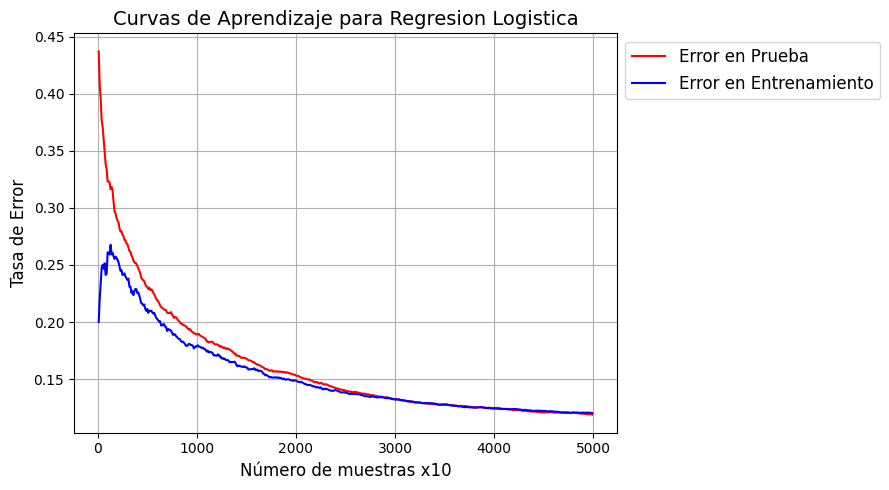

In [42]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 5000 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()